<a href="https://colab.research.google.com/github/anjaliii210/Cross-Market-Meta-Learner/blob/main/meta_fin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
#Define asset lists

equities = ['AAPL', 'MSFT', '^GSPC']       # Apple, Microsoft, S&P500
commodities = ['GC=F', 'SI=F', 'CL=F']     # Gold, Silver, Crude Oil (WTI)
forex = ['EURUSD=X', 'GBPUSD=X', 'USDJPY=X']  # 3 major currency pairs

assets = equities + commodities + forex

#Download data (2015–2025)
data = yf.download(assets, start='2015-01-01', end='2025-01-01')
#multiIndex columns into strings like 'Close_AAPL'
data.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data.columns]

# Convert index to datetime
data.index = pd.to_datetime(data.index)

# Create full daily date index
full_index = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')

# Reindex (this inserts weekends & holidays)
data = data.reindex(full_index)
data.index.name = 'date'


# Align to daily calendar and forward-fill holidays
data = data.ffill().bfill()


/tmp/ipython-input-1267623755.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(assets, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  9 of 9 completed


In [ ]:
#Feature Engineering

def compute_features(df):
    """Compute daily return, rolling volatility, and moving averages."""
    features = pd.DataFrame(index=df.index)
    features['return'] = df.pct_change()
    features['volatility'] = df.pct_change().rolling(10).std()
    features['ma_5'] = df.rolling(5).mean() / df - 1
    features['ma_20'] = df.rolling(20).mean() / df - 1
    return features

#filter only the closing prices
close_cols = [col for col in data.columns if col.startswith('Close_')]
print("Using these assets:", close_cols)

feature_list = []

#features only for closing prices
for asset in close_cols:
    feat = compute_features(data[asset])     # <- compute returns, MA, etc.
    feat['asset_id'] = asset                 # label the asset
    feat['target_next_day_return'] = feat['return'].shift(-1)
    feature_list.append(feat)


#Combine all assets

df_all = pd.concat(feature_list)
df_all.reset_index(inplace=True)
df_all.rename(columns={'index': 'date'}, inplace=True)

# Drop missing rows from rolling windows and last row (no next-day return)
df_all.dropna(inplace=True)

#Normalize per asset (z-score)
df_all[['return', 'volatility', 'ma_5', 'ma_20']] = (
    df_all.groupby('asset_id')[['return', 'volatility', 'ma_5', 'ma_20']]
    .transform(lambda x: (x - x.mean()) / x.std())
)

#Final aligned dataset

print(df_all.head())
print("\nAssets included:", df_all['asset_id'].unique())
print(f"\nFinal dataset shape: {df_all.shape}")

Using these assets: ['Close_AAPL', 'Close_CL=F', 'Close_EURUSD=X', 'Close_GBPUSD=X', 'Close_GC=F', 'Close_MSFT', 'Close_SI=F', 'Close_USDJPY=X', 'Close_^GSPC']
         date    return  volatility      ma_5     ma_20    asset_id  \
19 2015-01-20  1.678884    0.297940 -1.216188  0.146589  Close_AAPL   
20 2015-01-21  0.461550    0.343724 -1.275438 -0.066456  Close_AAPL   
21 2015-01-22  1.696203    0.356235 -2.134920 -0.744688  Close_AAPL   
22 2015-01-23  0.295364    0.341419 -1.659803 -0.840374  Close_AAPL   
23 2015-01-24 -0.051253    0.324564 -0.867147 -0.794339  Close_AAPL   

    target_next_day_return  
19                0.007634  
20                0.026015  
21                0.005160  
22                0.000000  
23                0.000000  

Assets included: ['Close_AAPL' 'Close_CL=F' 'Close_EURUSD=X' 'Close_GBPUSD=X' 'Close_GC=F'
 'Close_MSFT' 'Close_SI=F' 'Close_USDJPY=X' 'Close_^GSPC']

Final dataset shape: (32697, 7)


In [ ]:
print(data.columns[:10])

Index(['Close_AAPL', 'Close_CL=F', 'Close_EURUSD=X', 'Close_GBPUSD=X',
       'Close_GC=F', 'Close_MSFT', 'Close_SI=F', 'Close_USDJPY=X',
       'Close_^GSPC', 'High_AAPL'],
      dtype='object')


In [ ]:
# Split df_all into a dictionary of per-asset DataFrames
df_dict = {asset: df for asset, df in df_all.groupby('asset_id')}

Statistical Feature Extraction

In [ ]:
print(df_all['asset_id'].unique())
print(df_all['asset_id'].value_counts().head())

['Close_AAPL' 'Close_CL=F' 'Close_EURUSD=X' 'Close_GBPUSD=X' 'Close_GC=F'
 'Close_MSFT' 'Close_SI=F' 'Close_USDJPY=X' 'Close_^GSPC']
asset_id
Close_AAPL        3633
Close_CL=F        3633
Close_EURUSD=X    3633
Close_GBPUSD=X    3633
Close_GC=F        3633
Name: count, dtype: int64


In [ ]:
def summary_features(df_all):
  feature_vectors={}
  for asset,df in df_all.items():
    feats={}
    feats['return_mean']=df['return'].mean()
    feats['vol_mean']=df['volatility'].mean()
    feats['return_skew']=df['return'].skew()
    feats['return_kurt']=df['return'].kurtosis()
    feats['autocorr_1'] = df['return'].autocorr(lag=1)
    feats['corr_ret_vol'] = df['return'].corr(df['volatility'])
    feats['trend_frac'] = (df['return'] > 0).mean()
    feature_vectors[asset] = feats
  return pd.DataFrame(feature_vectors).T

In [ ]:
df_dict = {asset: df for asset, df in df_all.groupby('asset_id')}
summary_df = summary_features(df_dict)
display(summary_df)


,return_mean,vol_mean,return_skew,return_kurt,autocorr_1,corr_ret_vol,trend_frac
Close_AAPL,-1.320166e-17,-1.564641e-17,0.062631,9.079694,-0.062975,-0.002268,0.349023
Close_CL=F,9.779008e-19,-4.693924e-17,-38.767659,1901.713211,0.263349,-0.286314,0.684833
Close_EURUSD=X,-3.202625e-17,2.346962e-16,-0.023904,4.879400,-0.009600,0.008386,0.640793
Close_GBPUSD=X,-9.290058e-18,-5.085084e-17,-1.090359,20.906261,0.010777,-0.027509,0.642720
Close_GC=F,-8.801107e-18,1.877570e-16,-0.047435,6.807254,-0.026548,-0.011655,0.352326
Close_MSFT,4.889504e-19,-4.693924e-17,0.158173,12.665987,-0.115396,0.014424,0.350674
Close_SI=F,-2.933702e-18,1.564641e-16,-0.306142,8.556885,-0.044771,0.001216,0.345169
Close_USDJPY=X,-1.369061e-17,-1.251713e-16,-0.349152,5.999472,-0.007854,-0.027724,0.371869
Close_^GSPC,-5.378455e-18,-9.387848e-17,-0.591964,22.545112,-0.111056,-0.012319,0.355629


In [ ]:
print(data.index.to_series().diff().value_counts())

date
1 days    3652
Name: count, dtype: int64


no weekend gaps now, weekends have the price of the friday before

### Basic EDA

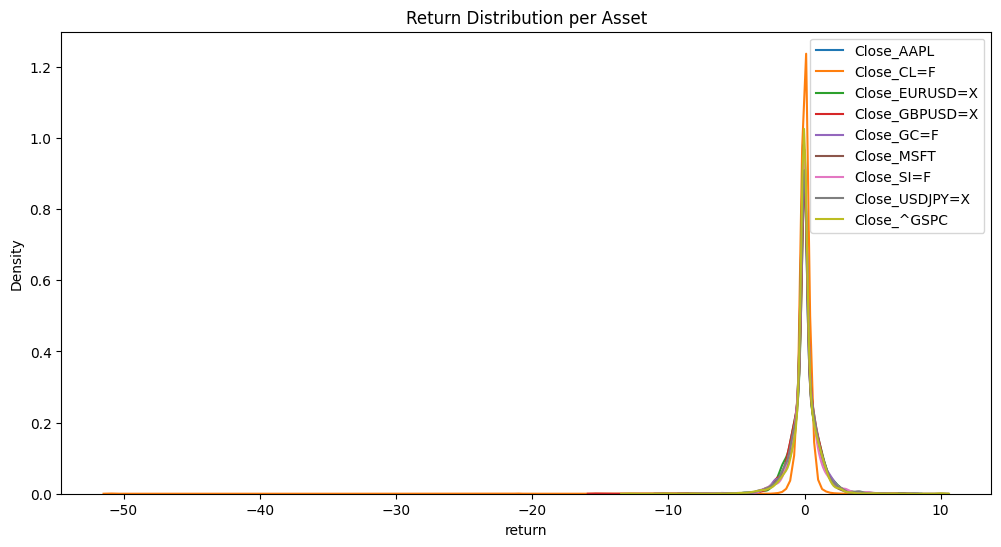

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,6))
for asset in df_all['asset_id'].unique():
    sns.kdeplot(df_all[df_all.asset_id==asset]['return'], label=asset)
plt.title("Return Distribution per Asset")
plt.legend()
plt.show()

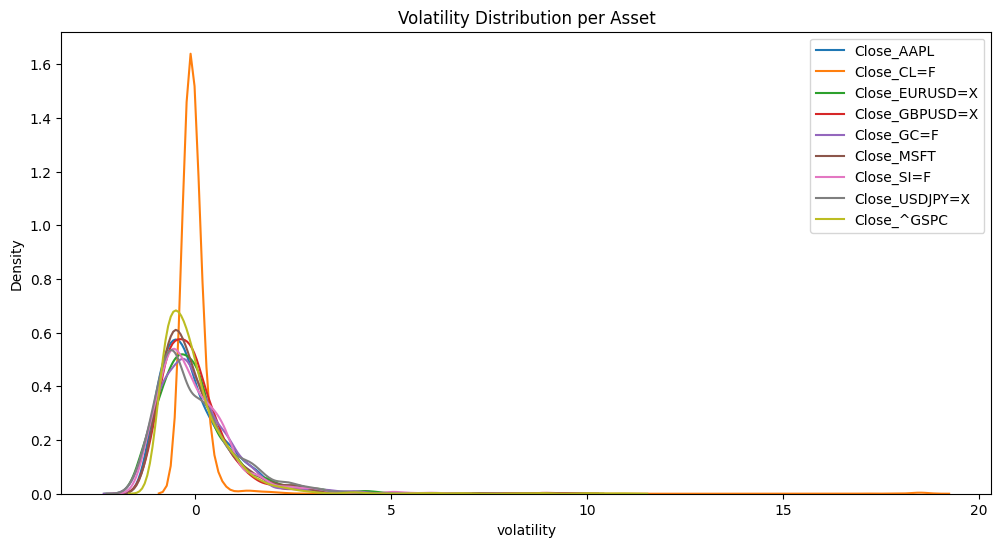

In [11]:
plt.figure(figsize=(12,6))
for asset in df_all['asset_id'].unique():
    sns.kdeplot(df_all[df_all.asset_id==asset]['volatility'], label=asset)
plt.title("Volatility Distribution per Asset")
plt.legend()
plt.show()

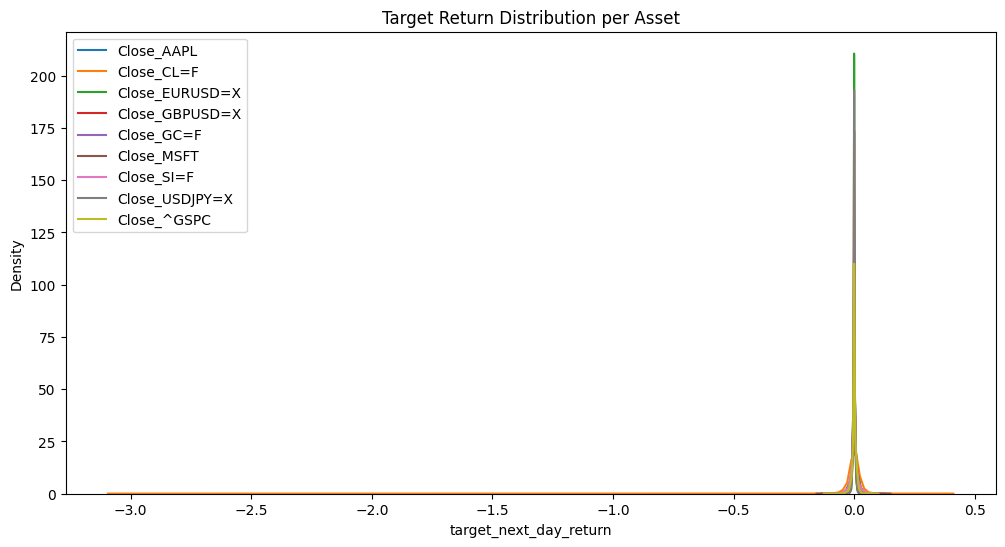

In [12]:
plt.figure(figsize=(12,6))
for asset in df_all['asset_id'].unique():
    sns.kdeplot(df_all[df_all.asset_id==asset]['target_next_day_return'], label=asset)
plt.title("Target Return Distribution per Asset")
plt.legend()
plt.show()

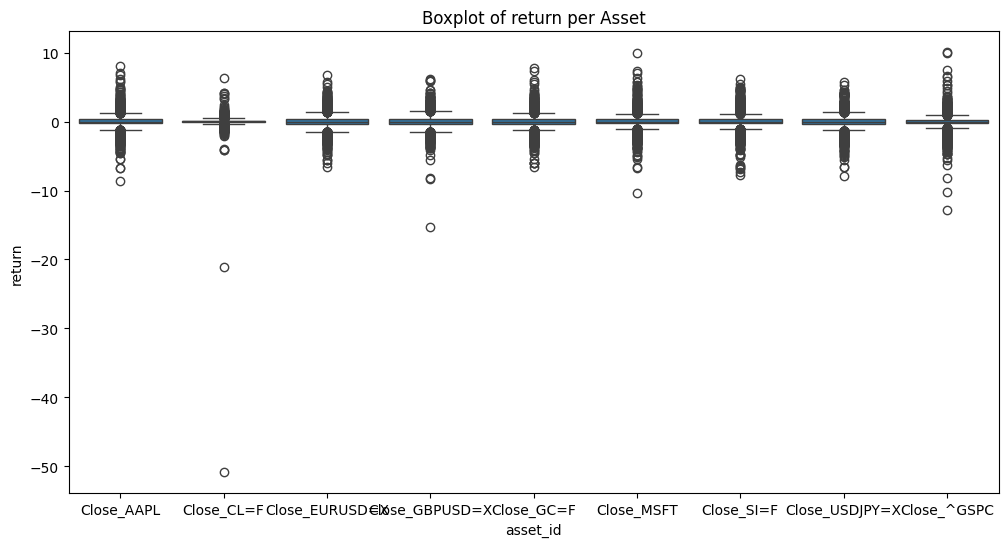

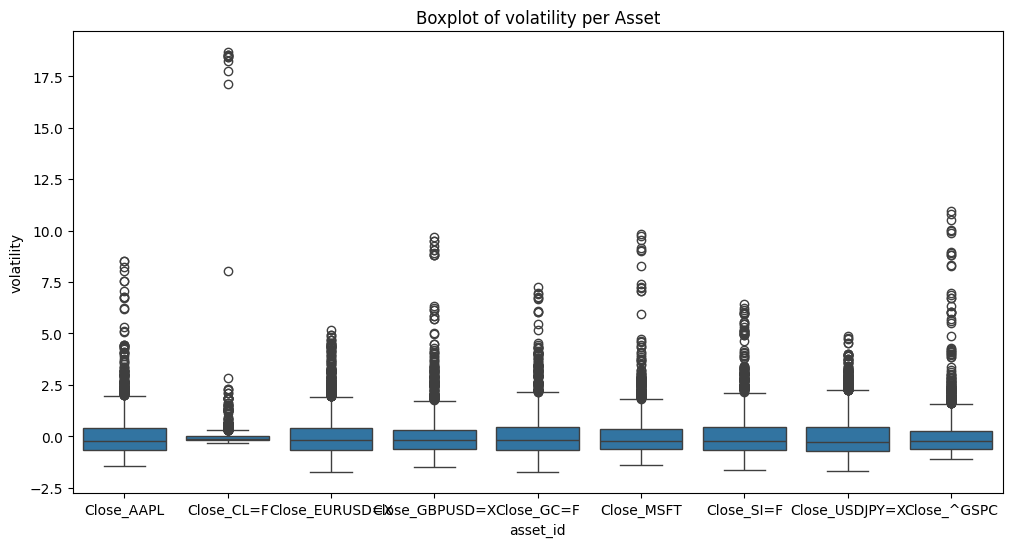

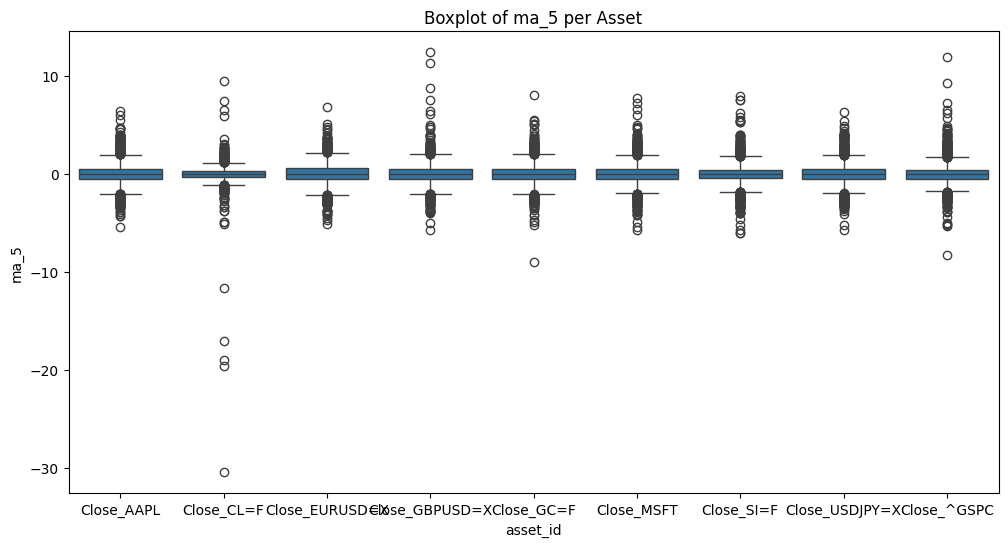

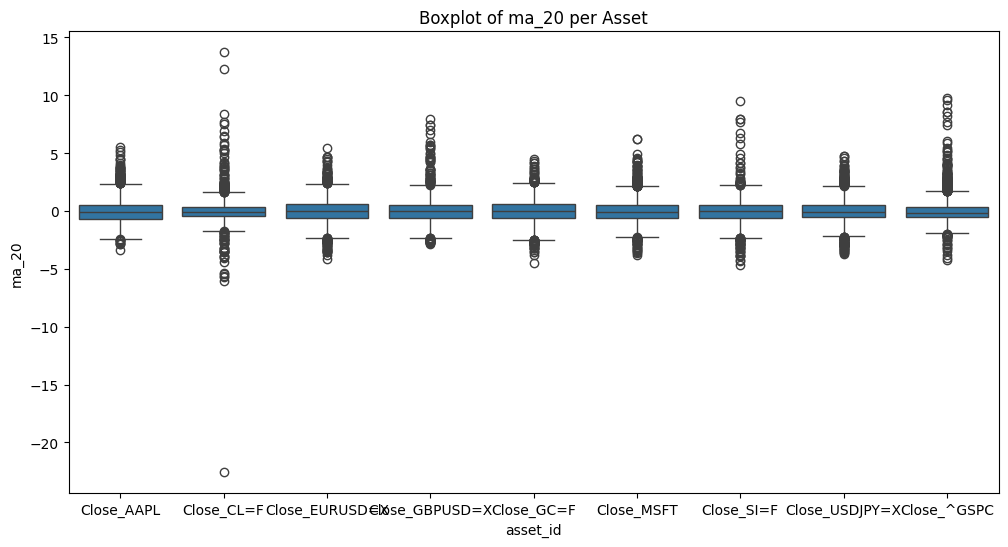

In [15]:
#boxplot per feature
features = ['return', 'volatility', 'ma_5', 'ma_20']
for f in features:
    plt.figure(figsize=(12,6))
    sns.boxplot(x=df_all['asset_id'], y=df_all[f])
    plt.title(f"Boxplot of {f} per Asset")
    plt.show()

<Axes: >

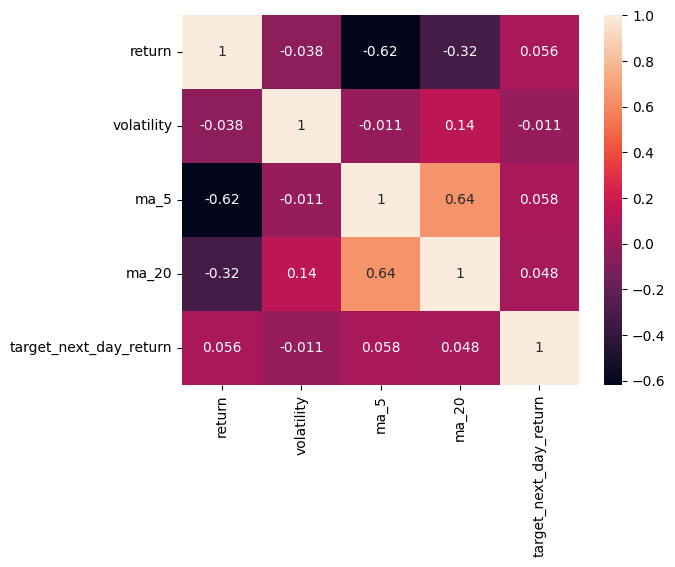

In [16]:
#correlation heatmap
sns.heatmap(df_all[['return','volatility','ma_5','ma_20','target_next_day_return']].corr(), annot=True)

In [17]:
def add_rolling_features(df, windows=[5, 10, 20]):
    for w in windows:
        df[f'ma_{w}'] = df['return'].rolling(w).mean()
        df[f'vol_{w}'] = df['return'].rolling(w).std()
        df[f'min_{w}'] = df['return'].rolling(w).min()
        df[f'max_{w}'] = df['return'].rolling(w).max()

    return df

In [18]:
def add_momentum_features(df):
    df['momentum_3'] = df['return'].rolling(3).sum()
    df['momentum_7'] = df['return'].rolling(7).sum()
    df['momentum_ratio_7_21'] = (
        df['return'].rolling(7).mean() /
        df['return'].rolling(21).mean()
    )
    return df

In [ ]:
def add_momentum_features(df):
    df['momentum_3'] = df['return'].rolling(3).sum()
    df['momentum_7'] = df['return'].rolling(7).sum()
    df['momentum_ratio_7_21'] = (
        df['return'].rolling(7).mean() /
        df['return'].rolling(21).mean()
    )
    return df

In [19]:
def add_higher_moments(df, window=20):                  #for rolling skewness and kurtosis
    df[f'skew_{window}'] = df['return'].rolling(window).skew()
    df[f'kurt_{window}'] = df['return'].rolling(window).kurt()
    return df


In [20]:
def compute_all_features(series):
    df = pd.DataFrame()
    df['date'] = series.index
    df['price'] = series.values

    # Returns
    df['return'] = df['price'].pct_change()

    # Apply your feature modules
    df = add_rolling_features(df)
    df = add_momentum_features(df)
    df = add_higher_moments(df)

    # Target (next-day return)
    df['target_next_day_return'] = df['return'].shift(-1)

    return df

In [21]:
df_list = []

for asset in data.columns:
    feat = compute_all_features(data[asset])
    feat['asset_id'] = asset
    df_list.append(feat)

df_all = pd.concat(df_list)
df_all = df_all.dropna()
df_all = df_all.set_index('date')

/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start, end, min_periods, *numba_args)
/usr/local/lib/python3.12/dist-packages/pandas/core/window/rolling.py:611: RuntimeWarning: All-NaN slice encountered
  return func(x, start,

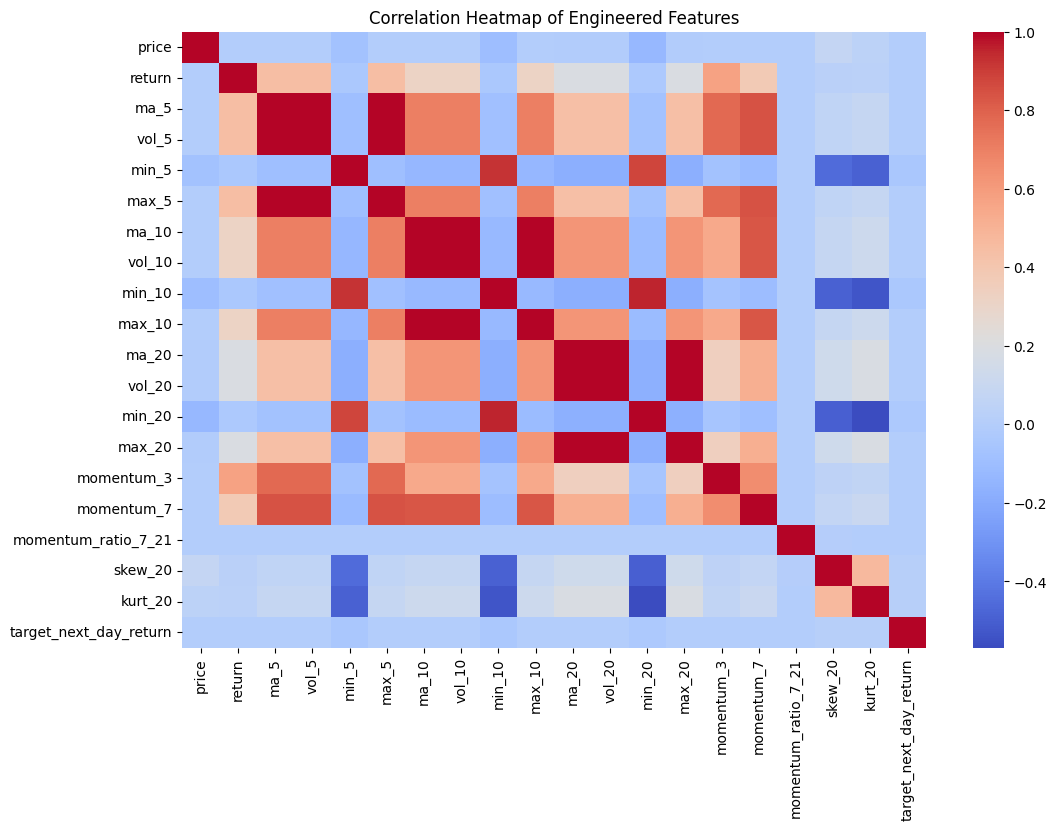

In [22]:
#corr heatmap for new features
numeric_df = df_all.select_dtypes(include=['float64', 'int64'])
corr = numeric_df.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap of Engineered Features")
plt.show()
